In [1]:
import json

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

2022-08-30 14:38:44.464257: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def _load_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return data

def load_results_to_df(json_results_patern):
    if isinstance(json_results_patern, list):
        json_files = []
        for patern in json_results_patern:
            json_files += tf.io.gfile.glob(patern)
    else:
        json_files = tf.io.gfile.glob(json_results_patern)
    
    results = [_load_json(jfile) for jfile in json_files]

    return pd.DataFrame(results)

def format_results(df):
    df['f_1^m'] = df['f1_score_cls'].apply(np.mean).round(3)
    df = df.drop(['f1_score_cls'], axis=1)
    
    df = pd.concat([df.drop(['acc_bins'], axis=1),
                      df['acc_bins'].apply(pd.Series).add_prefix('acc_')],
                     axis=1)
    df = df[['dataset', 'model', 'training_setup', 'acc_1', 'acc_2', 'acc_3', 'acc_4', 'acc_all', 'f_1^m']]
    df[['acc_1', 'acc_2', 'acc_3', 'acc_4', 'acc_all']] = (df[['acc_1', 'acc_2', 'acc_3', 'acc_4', 'acc_all']]*100).round(2)
    
    training_setup_name = {'repre': 'Baseline', 'crt': 'Sqrt-Samp', 'cbfocal': 'CBFocal', 'bags': 'BAGS', 'ssb': 'SSB (Ours)'}
    df['training_setup'] = df['training_setup'].map(training_setup_name)
    
    model_name = {'effv2b2': 'EfficientNetV2-B2', 'swin-s': 'Swin-S', 'resnet50': 'Resnet50', 'mbnetv3': 'MobileNetV3Large'}
    df['model'] = df['model'].map(model_name)
    
    dataset_name = {'serengeti': 'SS', 'wellington': 'Wellington', 'wcs': 'WCS', 'caltech': 'Caltech'}
    df['dataset'] = df['dataset'].map(dataset_name)
    
    model_sort = {
        'Resnet50': 0,
        'MobileNetV3Large': 1,
        'EfficientNetV2-B2': 2,
        'Swin-S': 3,
        'Baseline': 0,
        'Sqrt-Samp': 1,
        'CBFocal': 2,
        'BAGS': 3,
        'SSB (Ours)': 4,
        'SS': 0,
        'Wellington': 3, 
        'WCS': 1,
        'Caltech': 2
    }
    df = df.sort_values(by=['dataset', 'model', 'training_setup'], key=lambda x: x.map(model_sort))

    return df

In [3]:
results_json = ['/data/fagner/training/bags_paper/results/exp1/*_results.json',
                '/data/fagner/training/bags_paper/checkpoints/*_ssb_*/*_results.json']
results = load_results_to_df(results_json)
results = format_results(results)

In [4]:
def plot_f1(df, ax, title=None, hide_yaxis=True):
    colors = ["#47cba3", "#ff855a", "#9096cc", "#f46fc2", "#8de948"]
    ax.bar(df['training_setup'], df['f_1^m'], color=colors)
    
    xticks = ax.get_xticks()
    for x, y in zip(xticks, df['f_1^m']):
        ax.text(x, y, str(y),
                horizontalalignment="center",
                verticalalignment="bottom")
    
    ax.set_ylim([0, 0.695])
    if hide_yaxis:
        ax.axes.yaxis.set_visible(False)
    else:
        ax.set(ylabel='Macro F1-Score')

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    if title is not None:
        ax.set_title("%s" % title, fontsize=14)

def plot_all_f1_per_dataset(df, save_file):
    models = list(df.model.unique())

    fig, axs = plt.subplots(1, len(models), figsize=(12, 2.5))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.4, wspace=0.05)

    for i, model in enumerate(models):
        df_sel = df[df.model==model]
        plot_f1(df_sel, axs[i], model, hide_yaxis=i!=0)
    
    if save_file is not None:
        plt.savefig(save_file, bbox_inches='tight')
    plt.show()

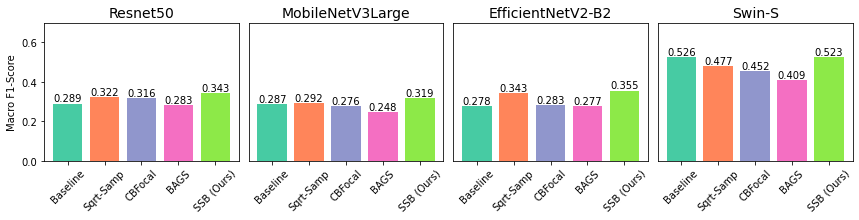

In [5]:
plot_all_f1_per_dataset(results[(results.dataset=='WCS')], '../data/wcs_fullimage_f1.pdf')

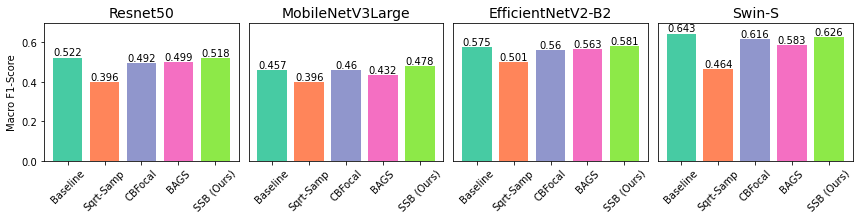

In [6]:
plot_all_f1_per_dataset(results[(results.dataset=='SS')], '../data/ss_fullimage_f1.pdf')

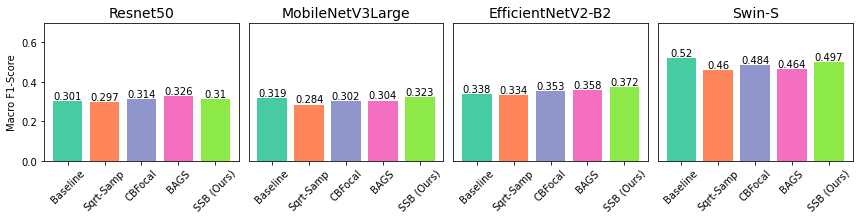

In [7]:
plot_all_f1_per_dataset(results[(results.dataset=='Caltech')], '../data/caltech_fullimage_f1.pdf')

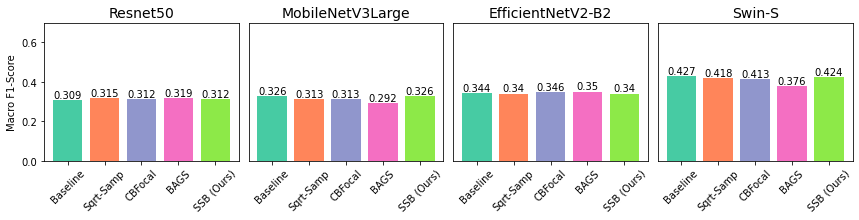

In [8]:
plot_all_f1_per_dataset(results[(results.dataset=='Wellington')], '../data/wellington_fullimage_f1.pdf')